In [1]:
#Pytorch 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gpytorch
import botorch 

import matplotlib.pyplot as plt

# Test Plots

In [2]:
#NN Surrogate model class
import injector_surrogate_quads
from injector_surrogate_quads import *
import physics_gp

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

In [3]:
# load injector model
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

2022-07-16 10:51:54.823930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
print(twiss0['x'])
print(twiss0['y'])

[1e-06, 1.113081026, -0.0689403587]
[1e-06, 1.113021659, -0.07029489754]


In [5]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(config): 
    """
    D is input space dimensionality
    :param config: input values of opt_var_names, torch.tensor, shape (1, D) 
    """
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around which to optimize
    x_in[:,:] = np.asarray(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    for i in range(config.size(dim=0)):
        x_in[:, Model.loc_in[opt_var_names[i]]] = config[i]

    #output predictions
    y_out = Model.pred_machine_units(x_in) 

    return -1*objective(y_out)[0]


def objective(y_out):
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:, Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:, Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = np.sqrt(out1 * out2)
  
    sigma_x = y_out[:, Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:, Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x, alpha_y = alpha0_x, alpha0_y
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * np.sqrt(beta0_x / beta_x) - alpha0_x * np.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * np.sqrt(beta0_y / beta_y) - alpha0_y * np.sqrt(beta_y / beta0_y))**2)
    bmag = np.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

## Set up initial training samples

In [6]:
test_param = 6 # from 0 to 8
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

#create initial samples within specified bounds
n_samples = 2
n_var = 9

scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])

train_x = scan_ref_point.repeat(n_samples, 1) 
train_x[0,test_param] = 1.0
train_x[1,test_param] = 3.0
# train_x[2,test_param] = -1.0
# train_x[3,test_param] = 4.0
# train_x[4,test_param] = 5.0


#train_x[:,0] = torch.linspace(bounds[0,0],bounds[0,1],n_samples)
print(train_x)
train_y = torch.tensor([evaluate(vars) for vars in train_x]).reshape(-1,1)
print(train_y)

#transformer 
transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
transformer_y = botorch.models.transforms.outcome.Standardize(1)

tensor([[ 4.7797e-01, -1.4992e-03, -6.8730e-04, -2.0006e+00,  2.0006e+00,
         -2.0218e-01,  1.0000e+00,  2.8522e+00, -3.2184e+00],
        [ 4.7797e-01, -1.4992e-03, -6.8730e-04, -2.0006e+00,  2.0006e+00,
         -2.0218e-01,  3.0000e+00,  2.8522e+00, -3.2184e+00]],
       dtype=torch.float64)


2022-07-16 10:51:56.619869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-16 10:51:56.635473: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996335000 Hz


tensor([[-3.7491],
        [-0.7949]], dtype=torch.float64)


In [7]:
# model 
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 20
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

In [8]:
from gpytorch.means.mean import Mean
class CustomMean(Mean):
    def __init__(self, name, y_norm_transform, outcome_transform):
        super(CustomMean, self).__init__()
        self.NN_model = NN_prior()
        self.NN_model.load_state_dict(torch.load('./results/' + name + '.pth'))
        self.NN_model.eval()
        
        self.y_norm_transform = y_norm_transform
        self.outcome_transform = outcome_transform
        
    def forward(self, x):
        """
        takes in transformed x, returns transformed y
        """
        self.outcome_transform.eval()
        
        m = self.NN_model(x) # normed x |-> NN normed y 
        m = self.y_norm_transform.untransform(m) # NN normed y -> real y
        m = self.outcome_transform(m)[0] # real y -> standardized y
        
        self.outcome_transform.train()
        return m.squeeze()
    
class Surrogate(Mean):
    def __init__(self, input_transform, outcome_transform):
        super(Surrogate, self).__init__()
        self.input_transform = input_transform 
        self.outcome_transform = outcome_transform

    def forward(self, x):
        """
        takes in transformed x, returns transformed y
        """
        self.input_transform.eval()
        self.outcome_transform.eval()
        
        x = self.input_transform.untransform(x) # normed x -> real x 
        m = torch.tensor([evaluate(vars) for vars in x]) # real x |-> real y
        m = self.outcome_transform(m)[0] # real y -> standardized y
        
        self.input_transform.eval() 
        self.outcome_transform.train()
        return m

### create GP

In [13]:
# model = botorch.models.SingleTaskGP(train_x, 
#                                     train_y, 
#                                     mean_module=MeanSquared(transformer_y), 
#                                     outcome_transform=transformer_y)

NN_transformer_y = botorch.models.transforms.input.Normalize(1)
NN_transformer_y.load_state_dict(torch.load('./results/transformer_y_3^9_norm.pth'))
NN_transformer_y.eval() 
        
const = botorch.models.SingleTaskGP(train_x, 
                                    train_y, 
                                    mean_module=None,
                                    input_transform=transformer_x,
                                    outcome_transform=transformer_y)
model = botorch.models.SingleTaskGP(train_x, 
                                    train_y, 
                                    mean_module=CustomMean("model3_1hidden_20nodes_500epoch_0.02", NN_transformer_y, transformer_y),
                                    input_transform=transformer_x,
                                    outcome_transform=transformer_y)
# model.covar_module.base_kernel.lengthscale = 0.1
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
# botorch.fit.fit_gpytorch_model(mll)

const.likelihood.noise_covar.noise = torch.tensor(1e-4)
model.likelihood.noise_covar.noise = torch.tensor(1e-4)

### plot GP in 1D

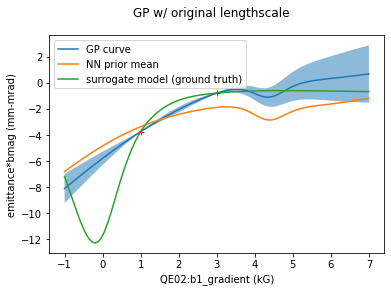

In [15]:
transformer_x.eval()

n_test = 100
test_x = scan_ref_point.repeat(n_test, 1)
test_x[:,test_param] = torch.linspace(bounds[test_param,0],bounds[test_param,1],n_test)
#print(test_x)

model.eval()
with torch.no_grad():
    real_post = model.posterior(test_x)
    real_mean = real_post.mean
    lower,upper = real_post.mvn.confidence_region()
    
    real_post1 = const.posterior(test_x)
    real_mean1 = real_post1.mean
    lower1,upper1 = real_post1.mvn.confidence_region()

NN_model = NN_prior()
NN_model.load_state_dict(torch.load('./results/model3_1hidden_20nodes_500epoch_0.02.pth'))

normed_prior_test_y = NN_model(transformer_x(test_x).float())
prior_test_y = NN_transformer_y.untransform(normed_prior_test_y)
#print(prior_test_y)
#print(transformer_y(prior_test_y)[0])
model_test_y = torch.as_tensor([evaluate(ele) for ele in test_x])
                               

fig,ax = plt.subplots()
fig.suptitle('GP w/ original lengthscale', fontsize=12)

ax.set_xlabel(opt_var_names[test_param] + ' (kG)', fontsize=10)
ax.set_ylabel('emittance*bmag (mm-mrad)', fontsize=10)

ax.plot(test_x[:,test_param], real_mean.flatten(), label = "GP curve")
# ax.plot(test_x[:,test_param], real_mean1.flatten(), label = "constant mean")
ax.plot(test_x[:,test_param], prior_test_y.detach().numpy(), label = "NN prior mean")
ax.plot(test_x[:,test_param], model_test_y.detach().numpy(), label = "surrogate model (ground truth)")
ax.plot(train_x[:,test_param], train_y, "+")

ax.fill_between(test_x[:,test_param],lower.flatten(),upper.flatten(),alpha = 0.5)
#ax.fill_between(test_x[:,test_param],lower1.flatten(),upper1.flatten(),alpha = 0.5)
ax.legend()